In [1]:
import KDEpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [2]:
data = pd.read_csv('data_KDE_1D.csv')
data

,data
0,4.945075
1,3.959293
2,5.653608
3,3.528821
4,4.189699
...,...
146,14.749228
147,14.671062
148,13.768554
149,15.386589


## a) Explore the data using suitable methods and tools.

Data Describe:
              data
count  151.000000
mean     9.913809
std      4.373194
min      2.557575
25%      5.250820
50%      9.952901
75%     14.527516
max     17.081593

Data Head:
        data
0  4.945075
1  3.959293
2  5.653608
3  3.528821
4  4.189699


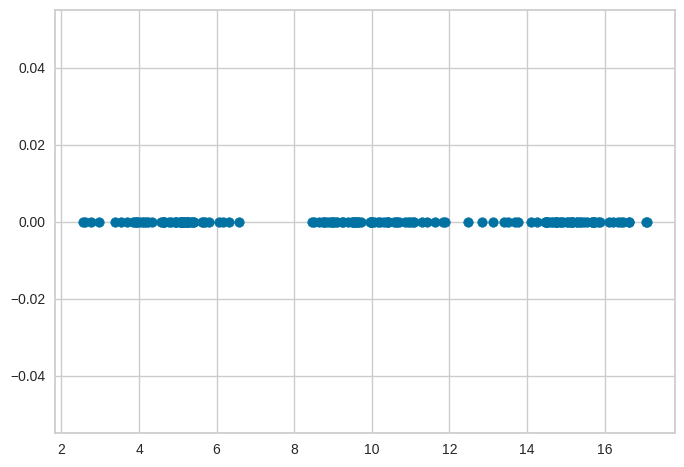

In [3]:
print("Data Describe:\r\n", data.describe())
print("\r\nData Head:\r\n", data.head())

xval = np.arange(len(data.index))
plt.scatter(data.iloc[:, 0], np.zeros(len(data)))

## b) Group the data to generate a meaningful histogram of the data.

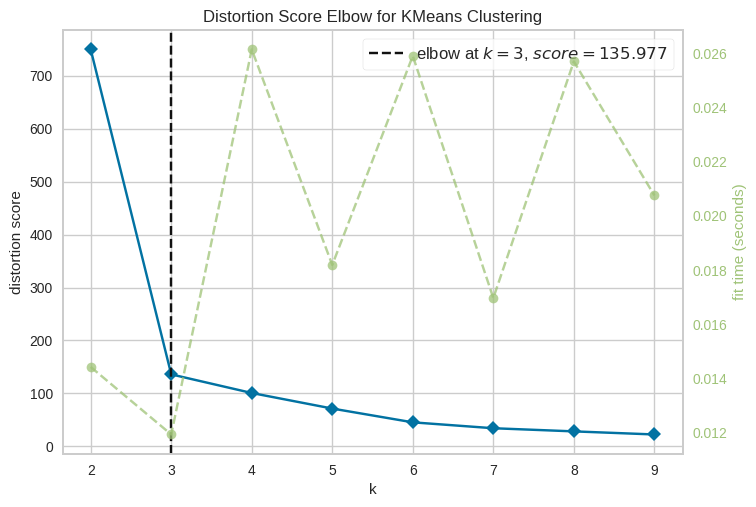

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [4]:
# Instantiate the clustering model and visualizer
# How many groups/clusters do we need?
# --> Look at the elbow
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(data)        # Fit the data to the visualizer
visualizer.show()

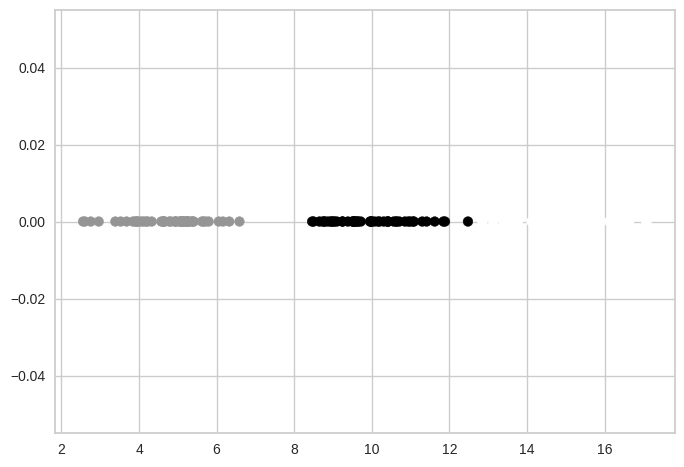

In [5]:
# Now we can perform kmean clustering...
kmean = KMeans(n_clusters=3).fit(data)

# ... which will generate one label for each data point
labels = kmean.predict(data)
plt.scatter(data.iloc[:, 0], np.zeros(len(data)), c=labels)

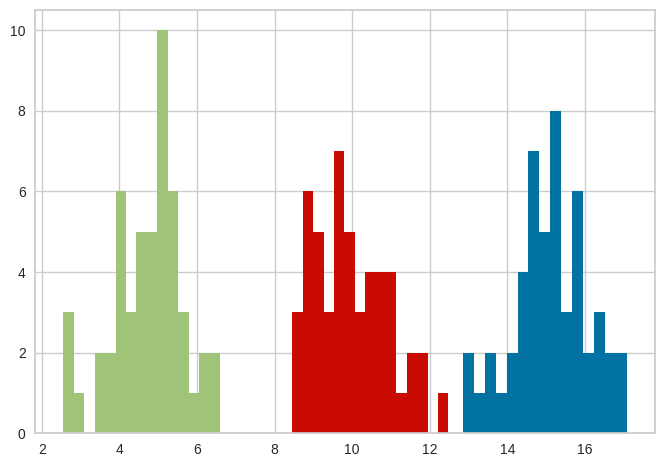

In [6]:
# Merge generated labels with data before plotting
data_with_labels = data
data_with_labels["label"] = labels

data_with_labels.groupby('label')['data'].hist(bins=15)
plt.show()

## c) Try to fit a normal distribution into the data. Plot the fitted normal distribution on top of the histogram. Hint: use scipy.stats.norm.fit to estimate the parameters of the normal distribution.

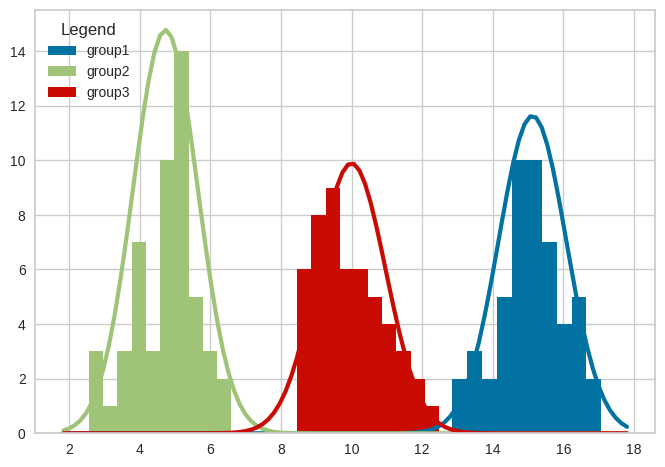

In [7]:
# Slice dataset into smaller groups according to labels
group1 = data.loc[data['label'] == 0, 'data']
group2 = data.loc[data['label'] == 1, 'data']
group3 = data.loc[data['label'] == 2, 'data']

# Plot grouped histograms the same as in b)
plt.hist(group1, label='group1')
plt.hist(group2, label='group2')
plt.hist(group3, label='group3')

# Fit normal distributions to each group
mu1, std1 = norm.fit(group1)
mu2, std2 = norm.fit(group2)
mu3, std3 = norm.fit(group3)

# Create dynamically-scaled x values
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Plot distribution functions using mu and std
p1 = norm.pdf(x, mu1, std1)
plt.plot(x, p1 * 28, 'b', linewidth=3)
p2 = norm.pdf(x, mu2, std2)
plt.plot(x, p2 * 34, 'g', linewidth=3)
p3 = norm.pdf(x, mu3, std3)
plt.plot(x, p3 * 24, 'r', linewidth=3)

plt.legend(title='Legend', loc='upper left')
plt.show()

## d) Multivariate kernel density estimation: Put a kernel (Gaussian, box, triangular) on top of every data point. Discuss the results. Hint: you can use python libraries such as KDEpy for your solution.

https://kdepy.readthedocs.io/en/latest/introduction.html

In [8]:
# Re-read data to work on a clean dataset
data = pd.read_csv('data_KDE_1D.csv')
data_array = data['data'].to_numpy()

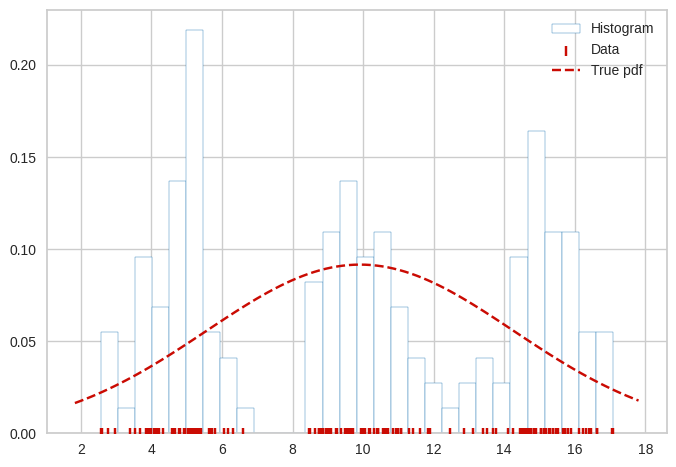

In [9]:
# This is our starting point plot
plt.hist(data, density=True, label='Histogram', edgecolor='#1f77b4', color='w', bins=30)

mu, std = norm.fit(data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p1 = norm.pdf(x, mu, std)

plt.scatter(data, np.zeros_like(data), marker='|',
            c='r', label='Data', zorder=9)
plt.plot(x, p1, label='True pdf', c='r', ls='--')
plt.legend(loc='best')
plt.show()

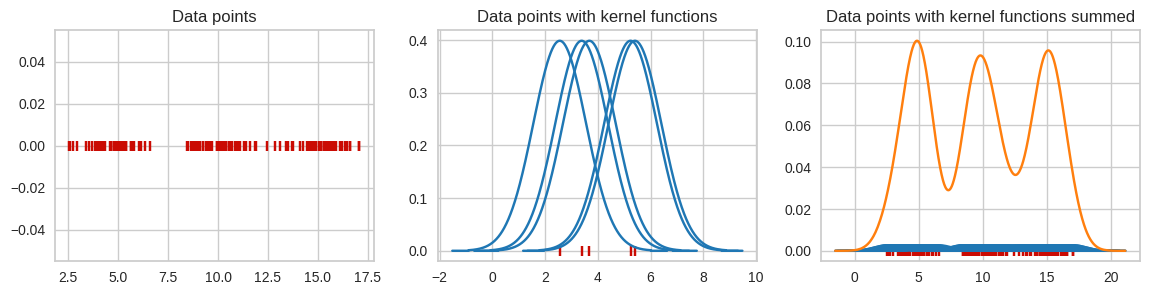

In [10]:
# Plot the points on a flat line
plt.figure(figsize=(14, 3));
plt.subplot(1, 3, 1)
plt.title('Data points')
plt.scatter(data_array, np.zeros_like(data_array), marker='|', c='r', label='Data')

# Plot a kernel on each data point
plt.subplot(1, 3, 2);
plt.title('Data points with kernel functions')

# We are not using the entire arry for better visualization
for i in range(5, 10):
    d = data_array[i]
    plt.scatter(d, 0, marker='|', c='r', label='Data')
    # Here the 'hat' is put on top of the datapoint
    x, y = KDEpy.TreeKDE(kernel='gaussian').fit([d])()
    plt.plot(x, y, color='#1f77b4')

# Plot a normalized kernel on each data point
plt.subplot(1, 3, 3);
plt.title('Data points with kernel functions summed')

plt.scatter(data_array, np.zeros_like(data_array), marker='|', c='r', label='Data')

for d in data_array:
    x, y = KDEpy.TreeKDE(kernel='gaussian').fit([d])()
    plt.plot(x, y / len(data), color='#1f77b4')

# ... and sum them afterwards(using the entire array to calculate the 'hats')
x, y = KDEpy.TreeKDE(kernel='gaussian').fit(data_array)()
plt.plot(x, y, color='#ff7f0e')
plt.show()

## e) Vary the parameters of the kernels (bandwidth, weights, ...) used in (d) and combine them to get a KDE.

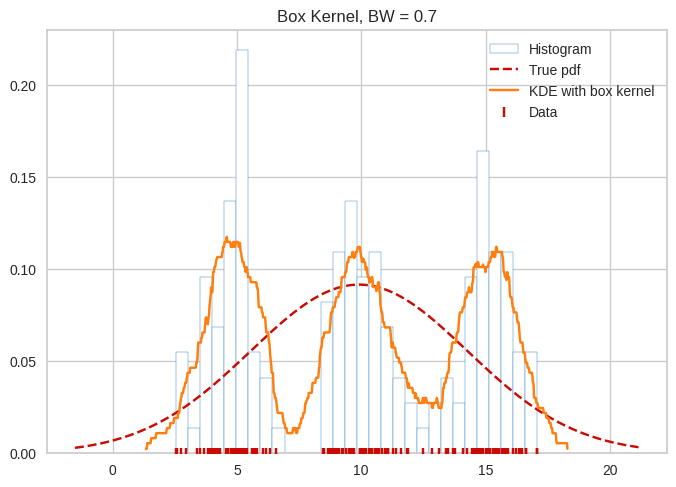

In [11]:
plt.hist(data_array, density=True, label='Histogram', edgecolor='#1f77b4', color='w', bins=30)

mu, std = norm.fit(data_array)
xmin, xmax = plt.xlim()

# Plot a 'normal' pdf for comparison
p1 = norm.pdf(x, mu, std)
plt.plot(x, p1, label='True pdf', c='r', ls='--')

# Use a box function with the FFTKDE to obtain a density estimate
x, y = KDEpy.FFTKDE(kernel='box', bw=0.7).fit(data_array).evaluate()
plt.plot(x, y, zorder=10, color='#ff7f0e', label='KDE with box kernel')
plt.scatter(data_array, np.zeros_like(data_array), marker='|', c='r', label='Data', zorder=9)

plt.legend(loc='best')
plt.title('Box Kernel, BW = 0.7')
plt.show()

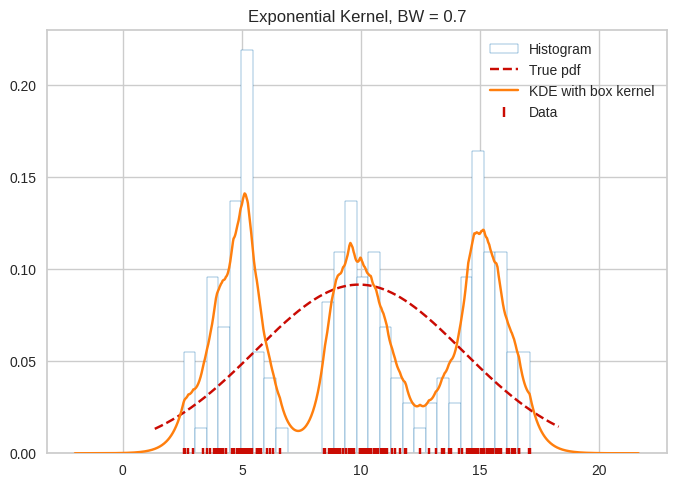

In [12]:
plt.hist(data_array, density=True, label='Histogram', edgecolor='#1f77b4', color='w', bins=30)

mu, std = norm.fit(data_array)
xmin, xmax = plt.xlim()

# Plot a 'normal' pdf for comparison
p1 = norm.pdf(x, mu, std)
plt.plot(x, p1, label='True pdf', c='r', ls='--')

# Use a exponential function with the FFTKDE to obtain a density estimate
x, y = KDEpy.FFTKDE(kernel='exponential', bw=0.7).fit(data_array).evaluate()
plt.plot(x, y, zorder=10, color='#ff7f0e', label='KDE with box kernel')
plt.scatter(data_array, np.zeros_like(data_array), marker='|', c='r', label='Data', zorder=9)

plt.legend(loc='best')
plt.title('Exponential Kernel, BW = 0.7')
plt.show()

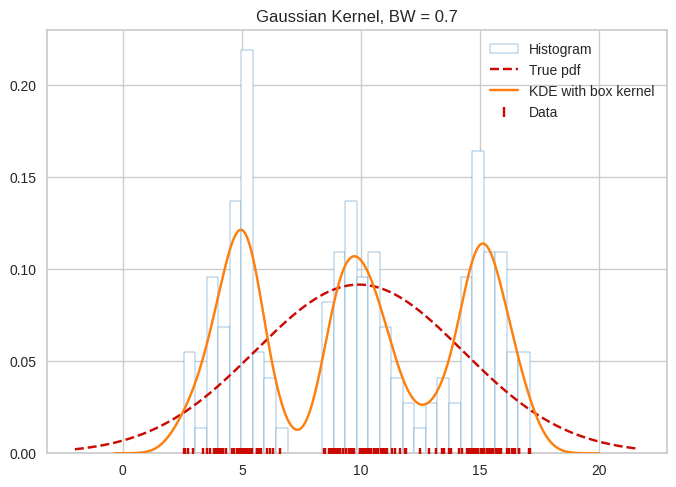

In [13]:
plt.hist(data_array, density=True, label='Histogram', edgecolor='#1f77b4', color='w', bins=30)

mu, std = norm.fit(data_array)
xmin, xmax = plt.xlim()

# Plot a 'normal' pdf for comparison
p1 = norm.pdf(x, mu, std)
plt.plot(x, p1, label='True pdf', c='r', ls='--')

# Use a box function with the FFTKDE to obtain a density estimate
x, y = KDEpy.FFTKDE(kernel='gaussian', bw=0.7).fit(data_array).evaluate()
plt.plot(x, y, zorder=10, color='#ff7f0e', label='KDE with box kernel')
plt.scatter(data_array, np.zeros_like(data_array), marker='|', c='r', label='Data', zorder=9)

plt.legend(loc='best')
plt.title('Gaussian Kernel, BW = 0.7')
plt.show()

# Gaussian Kernel - Play with bandwidth

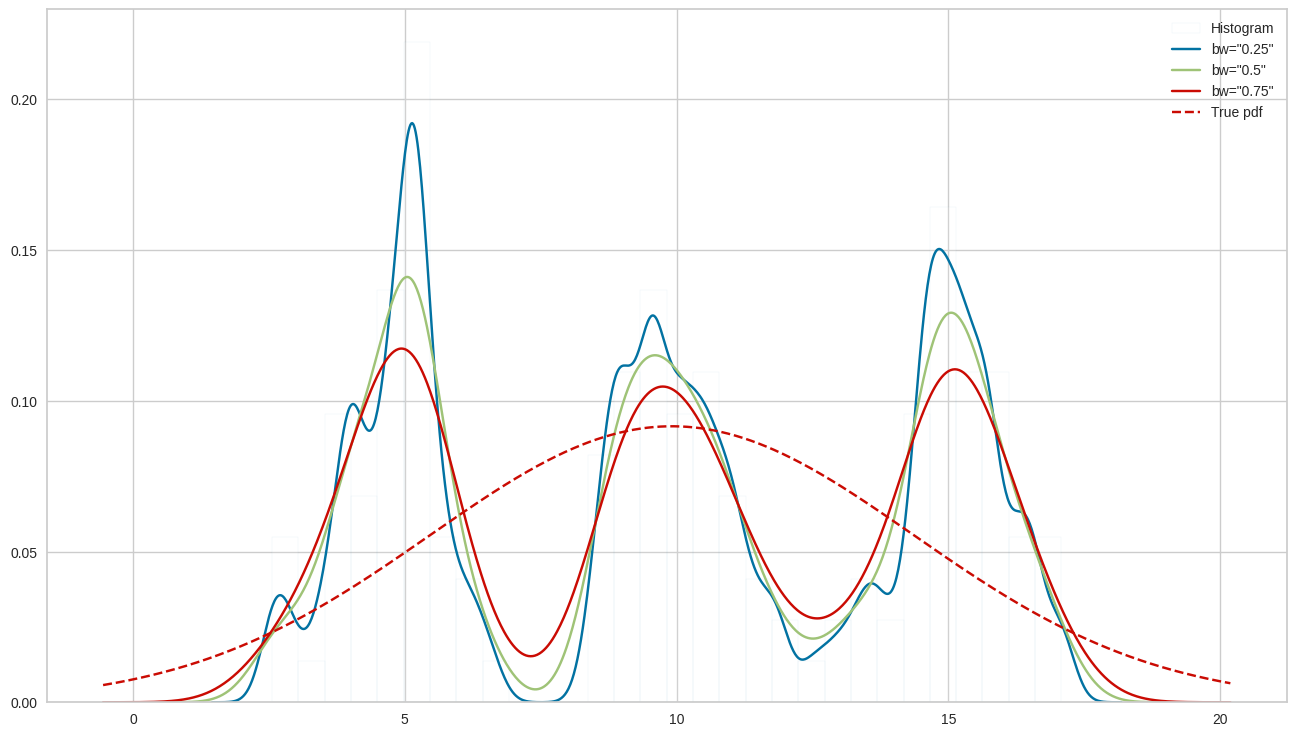

In [14]:
plt.figure(figsize=(16, 9))
plt.hist(data_array, density=True, label='Histogram', edgecolor='#1f77b4', color='w', bins=30, alpha=0.1)

# Plot a 'normal' pdf for comparison
mu, std = norm.fit(data_array)
xmin, xmax = plt.xlim()
p1 = norm.pdf(x, mu, std)

# Let's use some different bandwiths:
for bw in [0.25, 0.5, 0.75]:
    x, y = KDEpy.FFTKDE(kernel='gaussian', bw=bw).fit(data_array).evaluate()
    plt.plot(x, y, label='bw="{}"'.format(bw))

plt.plot(x, p1, label='True pdf', c='r', ls='--')
plt.legend(loc='best');

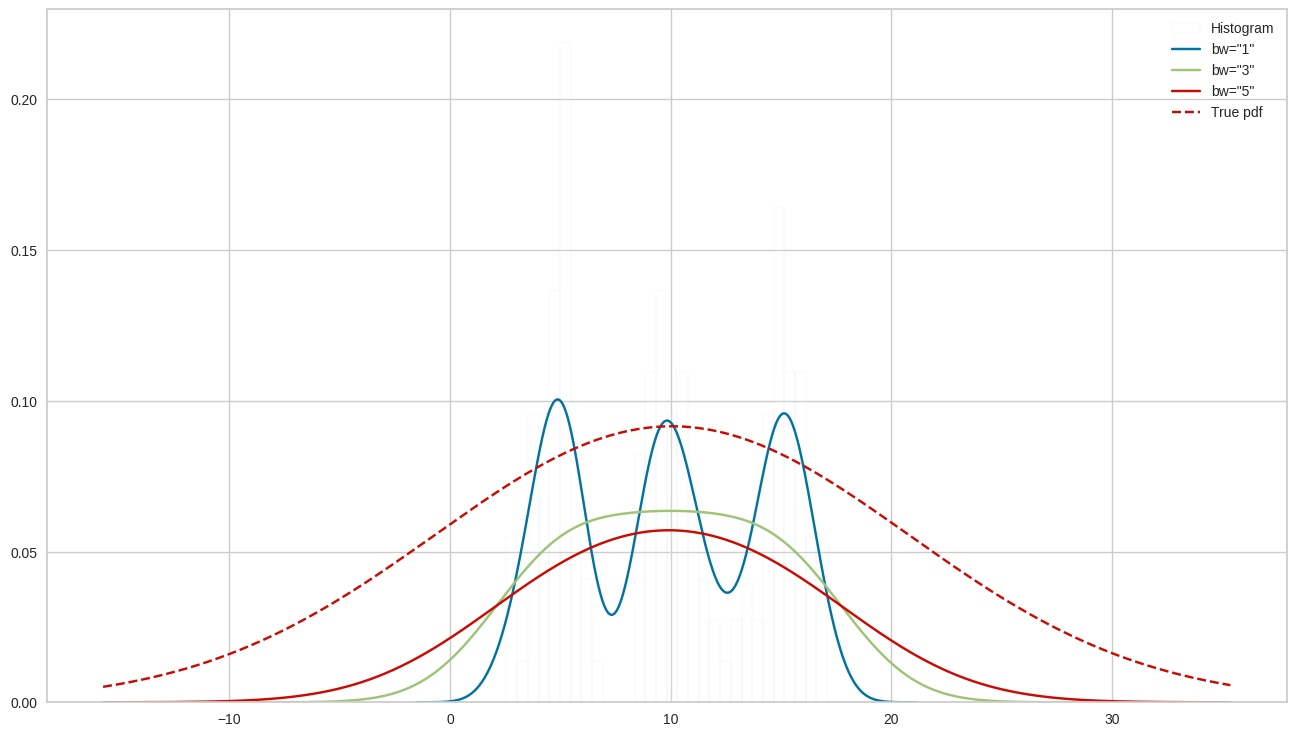

In [15]:
plt.figure(figsize=(16, 9))
plt.hist(data_array, density=True, label='Histogram', edgecolor='#1f77b4', color='w', bins=30, alpha=0.1)

# Plot a 'normal' pdf for comparison
mu, std = norm.fit(data_array)
xmin, xmax = plt.xlim()
p1 = norm.pdf(x, mu, std)

# Let's use some different bandwiths:
for bw in [1, 3, 5]:
    x, y = KDEpy.FFTKDE(kernel='gaussian', bw=bw).fit(data_array).evaluate()
    plt.plot(x, y, label='bw="{}"'.format(bw))

plt.plot(x, p1, label='True pdf', c='r', ls='--')
plt.legend(loc='best');

# Gaussian Kernel - Play with weights

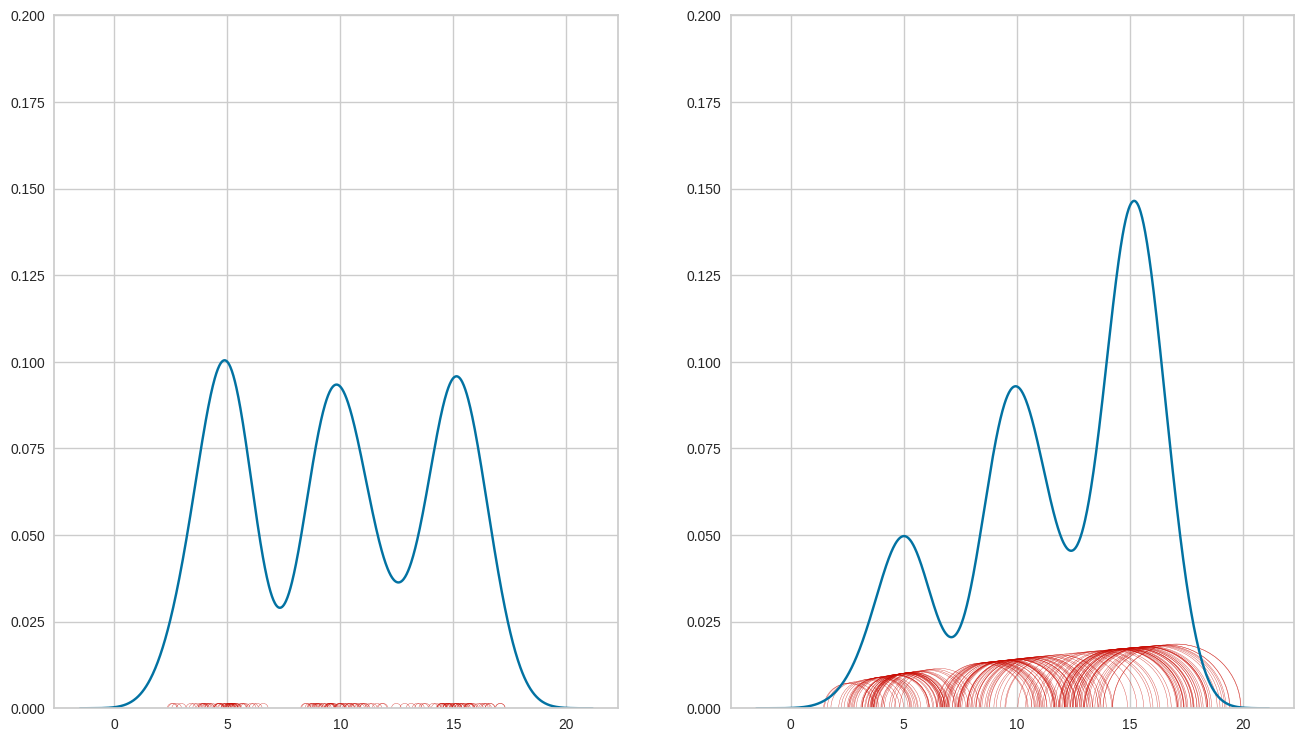

In [ ]:
plt.figure(figsize=(16, 9));
plt.subplot(1, 2, 1)
plt.scatter(data_array, np.zeros_like(data_array), marker='o', c='None', edgecolor='r', alpha=0.75)

# Unweighted KDE
x, y = KDEpy.FFTKDE().fit(data_array)()
plt.plot(x, y)
plt.ylim([0, 0.2])


# Weighted KDE
plt.subplot(1, 2, 2);
np.random.seed(123)
weights = data_array * 500
plt.scatter(data_array, np.zeros_like(data_array), marker='o', c='None', edgecolor='r', alpha=0.75, s=weights)

x, y = KDEpy.FFTKDE().fit(data_array, weights=weights)()
plt.plot(x, y)
plt.ylim([0, 0.2])
plt.show()
